## 1. Import Libraries ##

Fisrt, we import libraries

In [3]:
import os
import numpy as np
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import preprocess_input  # <-- DenseNet's specific preprocessing
import json
import matplotlib.pyplot as plt

In [1]:
import tensorflow as tf
# Ensure this block runs before any model or layers are defined
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')  # Use only the first GPU
        # Optionally, set memory growth if necessary
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Create logical GPUs (if needed)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

# Run functions eagerly
tf.config.run_functions_eagerly(True)

1 Physical GPUs, 1 Logical GPU


## 2. Define directiories

In [6]:
BASE_DIR = r"G:\OneDrive\ML-MinorProject\ISIC Dataset"
PROCESSED_TRAIN_DIR = os.path.join(BASE_DIR, "processed_train")
PROCESSED_VAL_DIR = os.path.join(BASE_DIR, "processed_val")
PROCESSED_TEST_DIR = os.path.join(BASE_DIR, "processed_test")

MODEL_DIR = r"G:\OneDrive\ML-MinorProject\models"
DENSENET_MODEL_PATH = os.path.join(MODEL_DIR, "densenet", "densenet121_best_model.h5")
DENSENET_TRAINING_HISTORY=os.path.join(MODEL_DIR, "densenet", "densenet_training_history.json")

## 3. Image Processing Configurations and Data Augmentation

We define the image processing configurations and create data generators.

In [7]:
# Adjusted hyperparameters for DenseNet121
IMG_SIZE = (224, 224)  # DenseNet121 input size
BATCH_SIZE = 16  # batch size

# Data augmentation and preprocessing configurations
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Preprocessing specific to DenseNet121, normalized pixel values for DenseNet
    rotation_range=30,                        # Slightly more aggressive rotation than others as DenseNet can handle it
    width_shift_range=0.15,                   # Slightly larger shifts
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    PROCESSED_TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Validation data generator
val_generator = val_datagen.flow_from_directory(
    PROCESSED_VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Testing data generator
test_generator = test_datagen.flow_from_directory(
    PROCESSED_TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 10730 images belonging to 2 classes.
Found 2944 images belonging to 2 classes.
Found 1994 images belonging to 2 classes.


## 4. Visualize Data Augmentation

We visualize some augmented images to ensure that the augmentations are applied correctly.

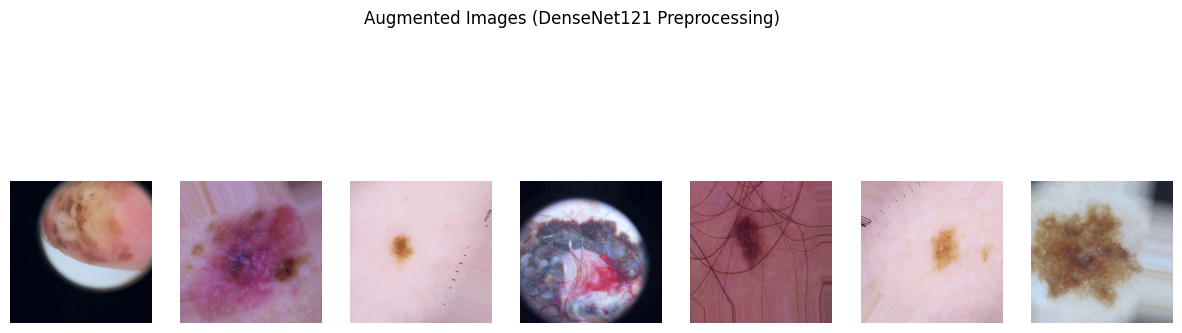

In [8]:
import matplotlib.pyplot as plt

def visualize_augmentation(generator):
    batch = next(generator)
    images = batch[0]  # Get the batch of images (input data)

    # Denormalize images for visualization
    # DenseNet preprocess_input subtracts mean, doesn't scale to [-1, 1]
    images = images.copy()
    images = (images - images.min()) / (images.max() - images.min())  # Rescale to [0,1] for display

    plt.figure(figsize=(15, 5))
    for i in range(7):
        plt.subplot(1, 7, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle("Augmented Images (DenseNet121 Preprocessing)")
    plt.show()

# Call the function to visualize augmented images
visualize_augmentation(train_generator)

## 5. Enable Mixed Precision

We enable mixed precision to improve training performance.

In [9]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1050 Ti, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


## 6. Define and Compile Model

We define and compile the DenseNet121 model architecture.

In [10]:
# Define the base model for DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build the full model
model = Sequential([
    base_model,                             # DenseNet121 as the base model
    GlobalAveragePooling2D(),               # Pooling layer
    Dropout(0.5),                           # Regularization with dropout
    Dense(1, activation='sigmoid', dtype='float32')  # Binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),   # Adam optimizer with a lower learning rate
    loss='binary_crossentropy',            # Loss function for binary classification
    metrics=['accuracy']                   # Metric to track during training
)

# Display the model summary
model.summary()

29084464/29084464 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


## 7. Define Callbacks

We define callbacks to improve the training process.

In [11]:
# Define the directory to save the model weights
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# Callback 1: EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=5,                   # Stop if no improvement after 5 epochs
    verbose=1,                    # Show log messages when stopping
    restore_best_weights=True     # Restore the best weights after stopping
)

# Callback 2: ModelCheckpoint
checkpoint = ModelCheckpoint(
    os.path.join(MODEL_DIR, "densenet_best_model.h5"),  # Path to save the best model
    monitor='val_loss',            # Monitor validation loss for the best model
    save_best_only=True,           # Only save the best model
    save_weights_only=True,        # Save only the weights
    verbose=1                      # Show log messages during saving
)

# Callback 3: ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',            # Monitor validation loss
    factor=0.5,                    # Reduce learning rate by a factor of 0.5
    patience=3,                    # Wait for 3 epochs before reducing the learning rate
    min_lr=1e-6,                   # Minimum learning rate limit
    verbose=1                      # Show log messages when learning rate is reduced
)

# Callback 4: TensorBoard
tensorboard = TensorBoard(
    log_dir=os.path.join(MODEL_DIR, 'logs'),  # Directory for TensorBoard logs
    histogram_freq=1,                          # Log histogram of weights every epoch
    write_graph=True,                          # Log the computation graph
    write_images=True                         # Log images (useful for visualizing filters)
)

# List of all callbacks
callbacks = [early_stopping, checkpoint, reduce_lr, tensorboard]

## 8. Train the Model

We train the model using the data generators.

In [12]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks  # Pass the callbacks list here
)

C:\Users\rikul\.conda\envs\py310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
671/671 [==============================] - ETA: 0s - loss: 0.3770 - accuracy: 0.8367
Epoch 1: val_loss improved from inf to 0.66277, saving model to G:\OneDrive\ML-MinorProject\models\densenet_best_model.h5
671/671 [==============================] - 831s 1s/step - loss: 0.3770 - accuracy: 0.8367 - val_loss: 0.6628 - val_accuracy: 0.7541 - lr: 1.0000e-04
Epoch 2/10
671/671 [==============================] - ETA: 0s - loss: 0.2965 - accuracy: 0.8741
Epoch 2: val_loss did not improve from 0.66277
671/671 [==============================] - 748s 1s/step - loss: 0.2965 - accuracy: 0.8741 - val_loss: 0.7388 - val_accuracy: 0.7717 - lr: 1.0000e-04
Epoch 3/10
671/671 [==============================] - ETA: 0s - loss: 0.2764 - accuracy: 0.8796
Epoch 3: val_loss did not improve from 0.66277
671/671 [==============================] - 813s 1s/step - loss: 0.2764 - accuracy: 0.8796 - val_loss: 0.7332 - val_accuracy: 0.7731 - lr: 1.0000e-04
Epoch 4/10
671/671 [=============================

## 9. Fine-Tune the Model

We unfreeze the base model and fine-tune the entire model.

In [13]:
# Unfreeze the last 50 layers of the base model
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='binary_crossentropy',          # Loss function for binary classification
    metrics=['accuracy']                 # Metric to track during training
)

# Continue training the model
history_finetune = model.fit(
    train_generator,
    epochs=10,                          # Continue training for another 10 epochs
    validation_data=val_generator,
    callbacks=callbacks                  # Use the callbacks defined earlier
)


Epoch 1/10
671/671 [==============================] - ETA: 0s - loss: 0.2905 - accuracy: 0.8708
Epoch 1: val_loss improved from 0.66277 to 0.58209, saving model to G:\OneDrive\ML-MinorProject\models\densenet_best_model.h5
671/671 [==============================] - 732s 1s/step - loss: 0.2905 - accuracy: 0.8708 - val_loss: 0.5821 - val_accuracy: 0.7857 - lr: 1.0000e-05
Epoch 2/10
671/671 [==============================] - ETA: 0s - loss: 0.2673 - accuracy: 0.8834
Epoch 2: val_loss did not improve from 0.58209
671/671 [==============================] - 704s 1s/step - loss: 0.2673 - accuracy: 0.8834 - val_loss: 0.7440 - val_accuracy: 0.7945 - lr: 1.0000e-05
Epoch 3/10
671/671 [==============================] - ETA: 0s - loss: 0.2596 - accuracy: 0.8879
Epoch 3: val_loss did not improve from 0.58209
671/671 [==============================] - 703s 1s/step - loss: 0.2596 - accuracy: 0.8879 - val_loss: 0.8130 - val_accuracy: 0.7860 - lr: 1.0000e-05
Epoch 4/10
671/671 [=========================

## 10. Save the Final Model

We save the final model after training and fine-tuning.

In [14]:
model.save(DENSENET_MODEL_PATH)
print(f"Final model saved to {DENSENET_MODEL_PATH}")

Final model saved to G:\OneDrive\ML-MinorProject\models\densenet\densenet121_best_model.h5


## 11. Save Training history
We save the training history of a model in a json file.

In [17]:
import pandas as pd
hist_df=pd.DataFrame(history.history)
with open(DENSENET_TRAINING_HISTORY, 'w') as f:
    hist_df.to_json(DENSENET_TRAINING_HISTORY)